# Hybrid Quantum Long-Short Term Memory NLP Example
The following example is adapted from the [official documentation](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html) of pytorch, with the purpose of comparing the results of pytorch's classical LSTM and our hybrid quantum implementation.

In brief, starting from an input sequence $w_1$, ..., $w_i \in \mathcal{V}$ and a tag series $\{y_j\}_{j=1,...i} \in \mathcal{T}$, being $\mathcal{V}$ our vocabulary and $\mathcal{T}$ our tag set, the model outputs a prediction $\hat{y1}, ..., \hat{y_M} \in \mathcal{T}$ applying the following prediction rule

\begin{equation}
\hat{y_i} = argmax_{j} \ log \ Softmax(Ah_i + b)
\end{equation}

Please have a look at pytorch's official documentation for further details.

In [29]:
# TODO: uncomment the next line after release qlearnkit 0.2.0
#!pip install qlearnkit['pennylane']
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [30]:
import qlearnkit as ql
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt


Let's first prepare our data

In [31]:
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index
ix_to_tag = {i: k for k, i in tag_to_ix.items()}


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}

# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index

print(f"Vocabulary: {word_to_ix}")
print(f"Entities: {ix_to_tag}")

Vocabulary: {'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}
Entities: {0: 'DET', 1: 'NN', 2: 'V'}


Now Let's create the Tagger model embedding our LSTM

In [32]:
class LSTMTagger(nn.Module):

    def __init__(self,
                 model,
                 embedding_dim,
                 hidden_dim,
                 vocab_size,
                 tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.model = model


        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.model(embeds.view(len(sentence), 1, -1))
        tag_logits = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_logits, dim=1)
        return tag_scores

Let's set (by hand) some hyperparameters

In [87]:
embedding_dim = 8
hidden_dim = 6
n_layers = 1
n_qubits = 4
n_epochs = 300
backend = 'default.qubit'

Let's also create an helper trainer that accepting our hyperparameters and a model, to simply call it with our two implementations

In [88]:
def trainer(lstm_model, embedding_dim, hidden_dim,
            n_epochs, model_label):
    # the LSTM Tagger Model
    model = LSTMTagger(lstm_model,
                   embedding_dim,
                   hidden_dim,
                   vocab_size=len(word_to_ix),
                   tagset_size=len(tag_to_ix))
    # loss function and Stochastic Gradient Descend
    # as optimizers
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    history = {
        'loss': [],
        'acc': []
    }
    for epoch in range(n_epochs):
        losses = []
        preds = []
        targets = []
        for sentence, tags in training_data:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = prepare_sequence(sentence, word_to_ix)
            labels = prepare_sequence(tags, tag_to_ix)

            # Step 3. Run our forward pass.
            tag_scores = model(sentence_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(tag_scores, labels)
            loss.backward()
            optimizer.step()
            losses.append(float(loss))

            probs = torch.softmax(tag_scores, dim=-1)
            preds.append(probs.argmax(dim=-1))
            targets.append(labels)
        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)

        # print("preds", preds)
        preds = torch.cat(preds)
        targets = torch.cat(targets)
        corrects = (preds == targets)
        accuracy = corrects.sum().float() / float(targets.size(0))
        history['acc'].append(accuracy)

        print(f"Epoch {epoch + 1} / {n_epochs}: Loss = {avg_loss:.3f} Acc = {accuracy:.2f}")

    with torch.no_grad():
        input_sentence = training_data[0][0]
        labels = training_data[0][1]
        inputs = prepare_sequence(input_sentence, word_to_ix)
        tag_scores = model(inputs)

        tag_ids = torch.argmax(tag_scores, dim=1).numpy()
        tag_labels = [ix_to_tag[k] for k in tag_ids]
        print(f"Sentence:  {input_sentence}")
        print(f"Labels:    {labels}")
        print(f"Predicted: {tag_labels}")

    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(history['loss'], label=f"{model_label} Loss")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy")
    ax2.plot(history['acc'], label=f"{model_label} LSTM Accuracy", color='tab:red')

    plt.title("Part-of-Speech Tagger Training")
    plt.ylim(0., 1.5)
    plt.legend(loc="upper right")

    plt.show()

Let's create our Quantum LSTM from qleanrkit

In [89]:
qlstm = ql.nn.QLongShortTermMemory(
    embedding_dim,
    hidden_dim,
    n_layers,
    n_qubits=n_qubits,
    device=backend
)

Let's have a look at its (quantum) architecture

**NOTICE:** ignore the following code per se, it has nothing to do with the actual usage of qlearnkit's QLSTM. It's just here to cope with the required parameters of `qml.draw`

In [90]:
# random values to feed into the QNode
inputs = torch.rand(embedding_dim, n_qubits)
weights = torch.rand(n_layers, n_qubits, 3)
import pennylane as qml
dev = qml.device(backend, wires=n_qubits)
circ = qml.QNode(qlstm._construct_vqc, dev)

print(qml.draw(circ, expansion_strategy='device', show_all_wires=True)(inputs, weights))

 0: ──H──RY(M0)──RZ(M4)──╭C─────────────────────────────╭X──RX(0.989)──RY(0.95)───RZ(0.787)──┤ ⟨Z⟩ 
 1: ──H──RY(M1)──RZ(M5)──╰X──╭C───RX(0.978)──RY(0.16)───│───RZ(0.859)────────────────────────┤ ⟨Z⟩ 
 2: ──H──RY(M2)──RZ(M6)──────╰X──╭C──────────RX(0.234)──│───RY(0.628)──RZ(0.612)─────────────┤ ⟨Z⟩ 
 3: ──H──RY(M3)──RZ(M7)──────────╰X─────────────────────╰C──RX(0.123)──RY(0.186)──RZ(0.642)──┤ ⟨Z⟩ 
M0 =
tensor([0.2950, 0.6869, 0.0673, 0.1683, 0.5993, 0.5091, 0.4533, 0.1108])
M1 =
tensor([0.2848, 0.2150, 0.0584, 0.6551, 0.5549, 0.4847, 0.4795, 0.5858])
M2 =
tensor([0.0385, 0.5281, 0.1947, 0.3548, 0.7059, 0.5676, 0.1746, 0.5629])
M3 =
tensor([0.2765, 0.3603, 0.7042, 0.2802, 0.3494, 0.5903, 0.6575, 0.3230])
M4 =
tensor([0.0921, 0.5921, 0.0045, 0.0289, 0.4365, 0.3020, 0.2330, 0.0124])
M5 =
tensor([0.0855, 0.0477, 0.0034, 0.5333, 0.3668, 0.2705, 0.2640, 0.4147])
M6 =
tensor([0.0015, 0.3280, 0.0389, 0.1364, 0.6284, 0.3862, 0.0311, 0.3790])
M7 =
tensor([0.0804, 0.1410, 0.6251, 0.0826, 0.1320, 0

Now we can train our hybrid-quantum model

Epoch 1 / 300: Loss = 1.162 Acc = 0.44
Epoch 2 / 300: Loss = 1.138 Acc = 0.44
Epoch 3 / 300: Loss = 1.116 Acc = 0.44
Epoch 4 / 300: Loss = 1.095 Acc = 0.44
Epoch 5 / 300: Loss = 1.079 Acc = 0.44
Epoch 6 / 300: Loss = 1.069 Acc = 0.44
Epoch 7 / 300: Loss = 1.061 Acc = 0.44
Epoch 8 / 300: Loss = 1.055 Acc = 0.44
Epoch 9 / 300: Loss = 1.050 Acc = 0.44
Epoch 10 / 300: Loss = 1.046 Acc = 0.44
Epoch 11 / 300: Loss = 1.041 Acc = 0.44
Epoch 12 / 300: Loss = 1.037 Acc = 0.44
Epoch 13 / 300: Loss = 1.034 Acc = 0.44
Epoch 14 / 300: Loss = 1.030 Acc = 0.44
Epoch 15 / 300: Loss = 1.027 Acc = 0.44
Epoch 16 / 300: Loss = 1.023 Acc = 0.44
Epoch 17 / 300: Loss = 1.019 Acc = 0.44
Epoch 18 / 300: Loss = 1.015 Acc = 0.44
Epoch 19 / 300: Loss = 1.011 Acc = 0.44
Epoch 20 / 300: Loss = 1.007 Acc = 0.44
Epoch 21 / 300: Loss = 1.002 Acc = 0.44
Epoch 22 / 300: Loss = 0.997 Acc = 0.44
Epoch 23 / 300: Loss = 0.991 Acc = 0.44
Epoch 24 / 300: Loss = 0.985 Acc = 0.44
Epoch 25 / 300: Loss = 0.978 Acc = 0.44
Epoch 26 

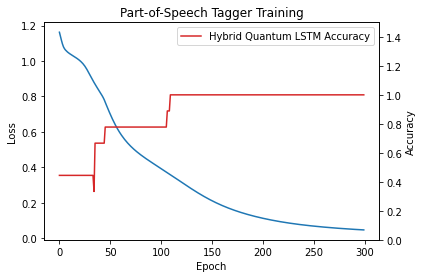

In [92]:
trainer(qlstm, embedding_dim, hidden_dim, n_epochs, model_label='Hybrid Quantum')

Let's compare it with the classical version

Epoch 1 / 300: Loss = 1.126 Acc = 0.22
Epoch 2 / 300: Loss = 1.116 Acc = 0.22
Epoch 3 / 300: Loss = 1.108 Acc = 0.33
Epoch 4 / 300: Loss = 1.100 Acc = 0.33
Epoch 5 / 300: Loss = 1.093 Acc = 0.44
Epoch 6 / 300: Loss = 1.087 Acc = 0.33
Epoch 7 / 300: Loss = 1.082 Acc = 0.33
Epoch 8 / 300: Loss = 1.077 Acc = 0.33
Epoch 9 / 300: Loss = 1.073 Acc = 0.33
Epoch 10 / 300: Loss = 1.069 Acc = 0.33
Epoch 11 / 300: Loss = 1.066 Acc = 0.44
Epoch 12 / 300: Loss = 1.062 Acc = 0.44
Epoch 13 / 300: Loss = 1.059 Acc = 0.44
Epoch 14 / 300: Loss = 1.057 Acc = 0.44
Epoch 15 / 300: Loss = 1.054 Acc = 0.44
Epoch 16 / 300: Loss = 1.051 Acc = 0.44
Epoch 17 / 300: Loss = 1.049 Acc = 0.44
Epoch 18 / 300: Loss = 1.046 Acc = 0.44
Epoch 19 / 300: Loss = 1.044 Acc = 0.44
Epoch 20 / 300: Loss = 1.042 Acc = 0.44
Epoch 21 / 300: Loss = 1.040 Acc = 0.44
Epoch 22 / 300: Loss = 1.038 Acc = 0.44
Epoch 23 / 300: Loss = 1.035 Acc = 0.44
Epoch 24 / 300: Loss = 1.033 Acc = 0.44
Epoch 25 / 300: Loss = 1.031 Acc = 0.44
Epoch 26 

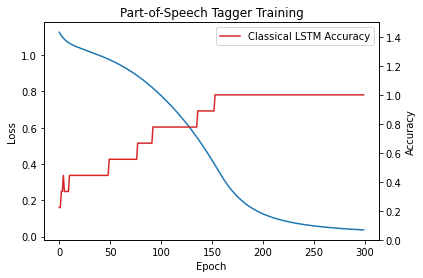

In [37]:
clstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers)
trainer(clstm, embedding_dim, hidden_dim, n_epochs,model_label='Classical')

In case you want to try with a different backend simulator you could also install `pennylane-qiskit` and play around with `qiskit.aer` or `qiskit.qasm`.

Be aware that it's gonna be way slower because of qiskit simulators.